Lidor Tubul - 318944402
Ronen Yakobov - 207688581


**Installs the langdetect library and imports necessary libraries**

In [5]:
!!pip install langdetect
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from langdetect import detect
import string
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**italicized textSets** up global variables and initialize the tokenizer and model "xlm-roberta-base" and loads the training data**

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
MAX_LENGTH = 128
NUM_EPOCHS = 25

# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
train = pd.read_csv('dev.csv') # data from https://www.kaggle.com/competitions/xlang-atd-hw/data

# sum all lables
train['Class'].value_counts()

,count
Class,
H,437
M,373


**checks the distribution of classes**

**display the first few rows of the training data**

In [13]:
# showing the data
train.head()

,ID,Text,Class
0,37829,Аустралия тілдері әлемдегі ең көне және байырғ...,M
1,54972,Rigter!Live is de naam van een eendaags popfes...,M
2,51318,"Di balik kelam ku dengar suara, \nMengalun le...",M
3,13701,"Di dalam hati yang sunyi dan dalam, \nAda ras...",M
4,127468,مرکز نے NSCN-IM کے ساتھ ملاقات کی، بات چیت کرن...,H


**defines two functions: get_multilingual_text_statistics to calculate text statistics like language, length, punctuation and analyze_multilingual_dataset to apply these statistics to a dataframe and analyze the language distribution**

In [14]:
def get_multilingual_text_statistics(text):
    """Calculate text statistics with language detection."""
    try:
        # detect language
        lang = detect(text)

        # basic statistics that work for all languages
        stats = {
            'language': lang,
            'total_length': len(text),
            'num_sentences': len(text.split('.')),  # simple sentence splitting
            'num_tokens': len(text.split()),  # simple token counting
            'avg_token_length': np.mean([len(token) for token in text.split()]),
            'punctuation_count': sum(1 for char in text if char in string.punctuation),
            'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text) if text else 0,
            'spaces_ratio': sum(1 for c in text if c.isspace()) / len(text) if text else 0,
            'digits_ratio': sum(1 for c in text if c.isdigit()) / len(text) if text else 0
        }

    except:
        # if language detection fails
        stats = {
            'language': 'unknown',
            'total_length': len(text),
            'num_sentences': 0,
            'num_tokens': 0,
            'avg_token_length': 0,
            'punctuation_count': 0,
            'uppercase_ratio': 0,
            'spaces_ratio': 0,
            'digits_ratio': 0
        }

    return stats

def analyze_multilingual_dataset(df):
    """Analyze entire multilingual dataset."""
    all_stats = []
    language_distribution = defaultdict(int)

    for text in tqdm(df['Text'], desc='Analyzing texts'):
        stats = get_multilingual_text_statistics(text)
        all_stats.append(stats)
        language_distribution[stats['language']] += 1

    stats_df = pd.DataFrame(all_stats)

    # print language distribution
    print("\nLanguage Distribution:")
    for lang, count in language_distribution.items():
        print(f"{lang}: {count} texts ({count/len(df)*100:.2f}%)")

    return stats_df

**defines a custom classifier class. it utilizes the "xlm-roberta-base" model for sequence classification and is customized for binary classification**

In [15]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()

        self.roberta = AutoModelForSequenceClassification.from_pretrained(
            "xlm-roberta-base",
            num_labels=2,
            problem_type="single_label_classification",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs.loss, outputs.logits if labels is not None else outputs.logits

**defines a custom dataset class to handle text data and labels. it tokenizes the text using the tokenizer and prepares the data for the model**

In [16]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None):
        """
        Prameters:
        texts: list of texts for classification
        labels: labels 0 for human text, 1 for machine text and none for test.
        """
        self.texts = texts # list of texts

        # list of lables for training dataset 0 - human generated 1 - AI generated
        # deafult option 'None' for test dataset
        self.labels = labels

    def __len__(self):
        """
        returns the number of samples in the dataset (required for pytorch Dataset object)
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        returns a specific example by index
        the method is called by PyTorch's DataLoader to get each batch item

        Parameters:
        idx: index of the desired example

        returns:
        dictionary with encoded text information and label (for train dataset)
        """
        # get the specific text from the list
        text = self.texts[idx]

        # encode the text using the tokenizer
        encoding = tokenizer(
            text,
            truncation=True,           # cut off texts that are too long
            max_length=MAX_LENGTH,            # maximum length of text
            padding='max_length',      # pad shorter texts to max_length
            return_tensors='pt'        # return pytorch tensors
        )

        # remove the extra dimension added by return_tensors='pt'
        # this converts tensors from shape [1, seq_len] to [seq_len]
        item = {key: val.squeeze(0) for key, val in encoding.items()}

        # add label to the item if it exists (for training data)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])

        return item

**loads the training and testing data, maps labels, splits the training data into training and validation sets, and creates dataset objects using the custom TextDataset class**

In [17]:
def prepare_data():
    # reading data
    train_df = pd.read_csv('dev.csv')
    test_df = pd.read_csv('test.csv')

    # label convertion
    label_map = {'H': 0, 'M': 1}
    train_df['label'] = train_df['Class'].map(label_map)

    # train_test_split
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['Text'].tolist(),
        train_df['label'].tolist(),
        test_size=0.1,
        random_state=42
    )

    # creating datasets
    train_dataset = TextDataset(train_texts, train_labels)
    val_dataset = TextDataset(val_texts, val_labels)
    test_dataset = TextDataset(test_df['Text'].tolist())

    return train_dataset, val_dataset, test_dataset, test_df

**trains and evaluates classical machine learning models (Random Forest, Logistic Regression, SVM-Linear) using TF-IDF features extracted from the text data.**

In [18]:
def train_multilingual_models(X_train, X_test, y_train, y_test):
    """train and evaluate models suitable for multilingual text."""
    # TF-IDF with character n-grams (works better for multiple languages)
    vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(3, 5),
        max_features=10000
    )

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM-Linear': LinearSVC(max_iter=1000)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        model.fit(X_train_tfidf, y_train)
        train_time = time.time() - start_time

        start_time = time.time()
        predictions = model.predict(X_test_tfidf)
        inference_time = time.time() - start_time

        accuracy = accuracy_score(y_test, predictions)

        results[name] = {
            'accuracy': accuracy,
            'training_time': train_time,
            'inference_time': inference_time,
            'classification_report': classification_report(y_test, predictions)
        }

        print(f"{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
        print("Classification Report:")
        print(results[name]['classification_report'])

    return results, vectorizer

def plot_multilingual_statistics(stats_df, labels):
    """create visualizations for multilingual text statistics."""
    # language distribution pie chart
    plt.figure(figsize=(12, 6))
    lang_counts = stats_df['language'].value_counts()
    plt.pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%')
    plt.title('Distribution of Languages in Dataset')
    plt.show()

    # box plots for numerical features
    numerical_cols = ['total_length', 'num_tokens', 'avg_token_length',
                     'punctuation_count', 'uppercase_ratio', 'digits_ratio']

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, col in enumerate(numerical_cols):
        sns.boxplot(x=labels, y=stats_df[col], ax=axes[i])
        axes[i].set_title(col.replace('_', ' ').title())

    plt.tight_layout()
    plt.show()

**trains the model for one epoch, calculating loss and accuracy for the training data.**

In [19]:
def train_one_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for batch in progress_bar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        optimizer.zero_grad()

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels']
        )
        loss = outputs[0]
        logits = outputs[1]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

**evaluate the model performance on the validation data, calculating loss and accuracy.**

In [20]:
def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            loss = outputs[0]
            logits = outputs[1]

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels


**generates predictions on the test data using the trained model and saves the predictions to a CSV file for submission**

In [21]:
def prepare_submission(model, test_dataset, test_df):
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Generating predictions'):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )

            preds = torch.argmax(outputs[1], dim=1)
            predictions.extend(preds.cpu().numpy())

    pred_labels = ['H' if p == 0 else 'M' for p in predictions]

    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'Class': pred_labels
    })

    submission_df.to_csv('submission.csv', index=False)
    return submission_df

defines two functions for visualization: plot_training_curves to plot the training and validation loss and accuracy over epochs, and plot_confusion_matrix to visualize the confusion matrix

In [22]:
# visualization
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Train Loss')
    plt.plot(val_losses, 'r-', label='Val Loss')
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(val_accuracies, 'r-', label='Val Accuracy')
    plt.title('Accuracy over time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, val_loader):
    _, _, preds, labels = evaluate(model, val_loader)
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


**orchestrates the entire process: loading data, analyzing text statistics, training and evaluating models, and preparing the submission file.**

In [23]:
def main():
    print("loading and preparing data...")
    train_df = pd.read_csv('dev.csv')
    test_df = pd.read_csv('test.csv')

    print("\nanalyzing text statistics...")
    stats_df = analyze_multilingual_dataset(train_df)
    plot_multilingual_statistics(stats_df, train_df['Class'])

    print("\npreparing for model comparison...")
    X = train_df['Text']
    y = (train_df['Class'] == 'M').astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # train and evaluate classical models
    print("\ntraining classical models...")
    classical_results, vectorizer = train_multilingual_models(X_train, X_test, y_train, y_test)

    # deep Learning model training
    print("\npreparing deep learning training...")
    train_dataset, val_dataset, test_dataset, test_df = prepare_data()

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = CustomClassifier().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    print("\nstarting deep learning training...")
    dl_start_time = time.time()
    best_val_accuracy = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(NUM_EPOCHS):
        print(f'\nepoch {epoch + 1}/{NUM_EPOCHS}')

        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_accuracy, _, _ = evaluate(model, val_loader)

        scheduler.step(val_accuracy)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}')
        print(f'val loss: {val_loss:.4f}, val accuracy: {val_accuracy:.4f}')
        print(f'current learning rate: {current_lr:.2e}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
            print(f'saving new model! accuracy: {val_accuracy:.4f}')

    dl_training_time = time.time() - dl_start_time

    print("\nPreparing submission...")
    submission_df = prepare_submission(model, test_dataset, test_df)
    print("Submission ready!")

    # print final comparison
    print("\nfinal results comparison:")
    print("\nclassical models:")
    for name, results in classical_results.items():
        print(f"\n{name}:")
        print(f"accuracy: {results['accuracy']:.4f}")
        print(f"training Time: {results['training_time']:.2f} seconds")
        print(f"inference Time: {results['inference_time']:.2f} seconds")

    print("\ndeep learning model:")
    print(f"best validation accuracy: {best_val_accuracy:.4f}")
    print(f"total training time: {dl_training_time:.2f} seconds")

    return model, submission_df, (train_losses, val_losses, train_accuracies, val_accuracies), val_dataset, classical_results, stats_df

**executes the main function main when the script is running. it also calls the visualization functions to display training curves and the confusion matrix.**

loading and preparing data...

analyzing text statistics...


Analyzing texts: 100%|██████████| 810/810 [00:05<00:00, 153.06it/s]



Language Distribution:
uk: 12 texts (1.48%)
nl: 49 texts (6.05%)
id: 72 texts (8.89%)
ur: 63 texts (7.78%)
hi: 67 texts (8.27%)
en: 9 texts (1.11%)
es: 56 texts (6.91%)
ja: 53 texts (6.54%)
zh-cn: 67 texts (8.27%)
vi: 69 texts (8.52%)
ru: 110 texts (13.58%)
he: 18 texts (2.22%)
it: 59 texts (7.28%)
no: 29 texts (3.58%)
ar: 48 texts (5.93%)
de: 28 texts (3.46%)
sv: 1 texts (0.12%)


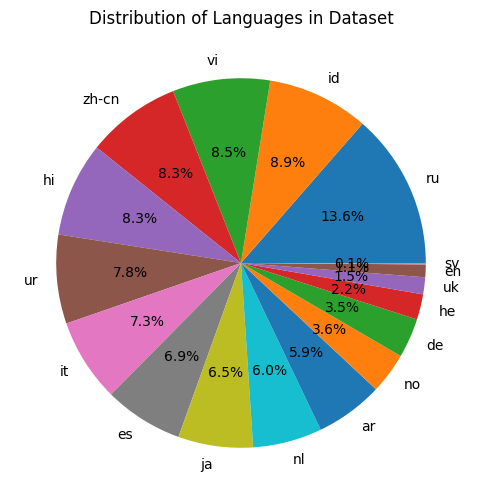

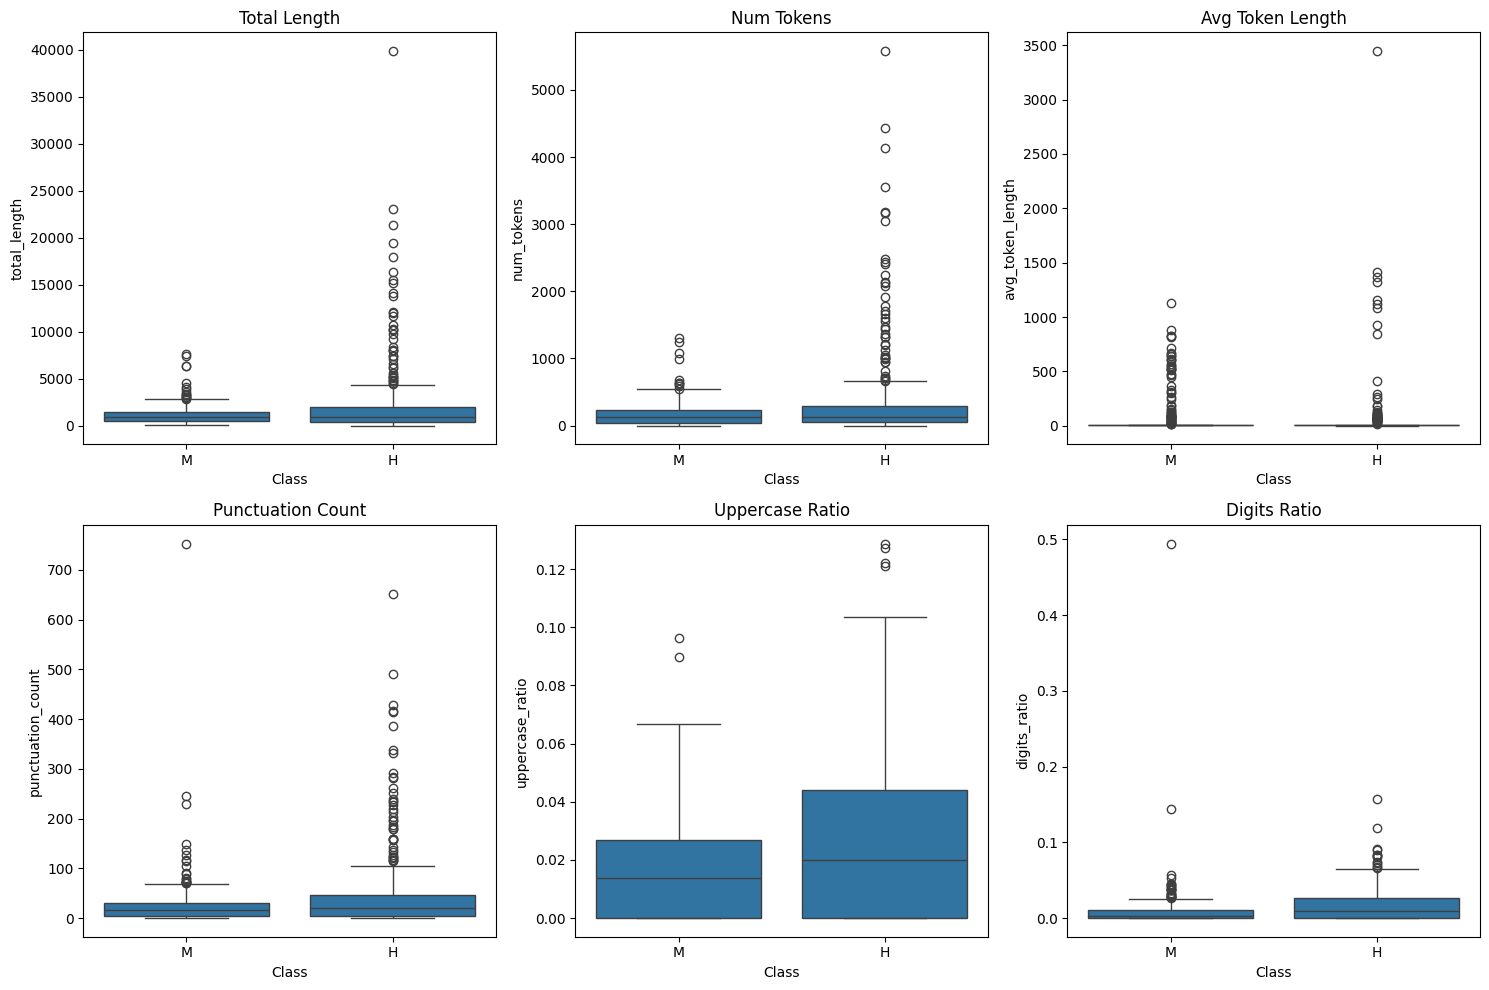


preparing for model comparison...

training classical models...

Training Random Forest...
Random Forest Results:
Accuracy: 0.7901
Training Time: 1.30 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        38
           1       0.88      0.70      0.78        43

    accuracy                           0.79        81
   macro avg       0.80      0.80      0.79        81
weighted avg       0.81      0.79      0.79        81


Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7284
Training Time: 0.04 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.89      0.76        38
           1       0.86      0.58      0.69        43

    accuracy                           0.73        81
   macro avg       0.76      0.74      0.72        81
weighted avg       0.76      0.73      0.72        81


Training SVM-Linear...
SVM-Linea

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



starting deep learning training...

epoch 1/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.33it/s, loss=0.677]


train loss: 0.6910, train accuracy: 0.5514
val loss: 0.6902, val accuracy: 0.5185
current learning rate: 1.00e-05
saving new model! accuracy: 0.5185

epoch 2/25


Training: 100%|██████████| 23/23 [00:16<00:00,  1.38it/s, loss=0.656]


train loss: 0.6734, train accuracy: 0.5638
val loss: 0.6746, val accuracy: 0.5556
current learning rate: 1.00e-05
saving new model! accuracy: 0.5556

epoch 3/25


Training: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s, loss=0.44]


train loss: 0.6027, train accuracy: 0.6996
val loss: 0.6228, val accuracy: 0.6914
current learning rate: 1.00e-05
saving new model! accuracy: 0.6914

epoch 4/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s, loss=0.32]


train loss: 0.4482, train accuracy: 0.8107
val loss: 0.6451, val accuracy: 0.6790
current learning rate: 1.00e-05

epoch 5/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.33it/s, loss=0.499]


train loss: 0.3013, train accuracy: 0.8875
val loss: 0.7195, val accuracy: 0.6914
current learning rate: 1.00e-05

epoch 6/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.125]


train loss: 0.1847, train accuracy: 0.9561
val loss: 0.8183, val accuracy: 0.6914
current learning rate: 5.00e-06

epoch 7/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s, loss=0.0469]


train loss: 0.1206, train accuracy: 0.9726
val loss: 0.8359, val accuracy: 0.7407
current learning rate: 5.00e-06
saving new model! accuracy: 0.7407

epoch 8/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.0651]


train loss: 0.0737, train accuracy: 0.9822
val loss: 0.8513, val accuracy: 0.7901
current learning rate: 5.00e-06
saving new model! accuracy: 0.7901

epoch 9/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s, loss=0.0596]


train loss: 0.0649, train accuracy: 0.9822
val loss: 0.9213, val accuracy: 0.7654
current learning rate: 5.00e-06

epoch 10/25


Training: 100%|██████████| 23/23 [00:18<00:00,  1.28it/s, loss=0.00711]


train loss: 0.0456, train accuracy: 0.9959
val loss: 1.0777, val accuracy: 0.7284
current learning rate: 5.00e-06

epoch 11/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.0202]


train loss: 0.0425, train accuracy: 0.9945
val loss: 1.2351, val accuracy: 0.7407
current learning rate: 2.50e-06

epoch 12/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s, loss=0.0166]


train loss: 0.0371, train accuracy: 0.9973
val loss: 1.0380, val accuracy: 0.8025
current learning rate: 2.50e-06
saving new model! accuracy: 0.8025

epoch 13/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.0114]


train loss: 0.0197, train accuracy: 0.9986
val loss: 1.2652, val accuracy: 0.7531
current learning rate: 2.50e-06

epoch 14/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s, loss=0.0409]


train loss: 0.0212, train accuracy: 0.9986
val loss: 1.3050, val accuracy: 0.7531
current learning rate: 2.50e-06

epoch 15/25


Training: 100%|██████████| 23/23 [00:18<00:00,  1.28it/s, loss=0.02]


train loss: 0.0285, train accuracy: 0.9945
val loss: 1.1170, val accuracy: 0.7901
current learning rate: 1.25e-06

epoch 16/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s, loss=0.00617]


train loss: 0.0178, train accuracy: 0.9973
val loss: 1.3348, val accuracy: 0.7531
current learning rate: 1.25e-06

epoch 17/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s, loss=0.0273]


train loss: 0.0162, train accuracy: 0.9973
val loss: 1.5228, val accuracy: 0.7160
current learning rate: 1.25e-06

epoch 18/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s, loss=0.00317]


train loss: 0.0171, train accuracy: 0.9986
val loss: 1.3762, val accuracy: 0.7531
current learning rate: 6.25e-07

epoch 19/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s, loss=0.00482]


train loss: 0.0195, train accuracy: 0.9973
val loss: 1.4722, val accuracy: 0.7407
current learning rate: 6.25e-07

epoch 20/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s, loss=0.0285]


train loss: 0.0194, train accuracy: 0.9959
val loss: 1.4848, val accuracy: 0.7284
current learning rate: 6.25e-07

epoch 21/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.0116]


train loss: 0.0215, train accuracy: 0.9973
val loss: 1.5000, val accuracy: 0.7284
current learning rate: 3.13e-07

epoch 22/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.00999]


train loss: 0.0133, train accuracy: 0.9986
val loss: 1.4868, val accuracy: 0.7284
current learning rate: 3.13e-07

epoch 23/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.00707]


train loss: 0.0126, train accuracy: 0.9986
val loss: 1.4600, val accuracy: 0.7284
current learning rate: 3.13e-07

epoch 24/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s, loss=0.00519]


train loss: 0.0125, train accuracy: 0.9986
val loss: 1.4483, val accuracy: 0.7284
current learning rate: 1.56e-07

epoch 25/25


Training: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.00597]


train loss: 0.0160, train accuracy: 0.9973
val loss: 1.4648, val accuracy: 0.7284
current learning rate: 1.56e-07

Preparing submission...


Generating predictions: 100%|██████████| 228/228 [01:02<00:00,  3.67it/s]


Submission ready!

final results comparison:

classical models:

Random Forest:
accuracy: 0.7901
training Time: 1.30 seconds
inference Time: 0.02 seconds

Logistic Regression:
accuracy: 0.7284
training Time: 0.04 seconds
inference Time: 0.00 seconds

SVM-Linear:
accuracy: 0.8148
training Time: 0.04 seconds
inference Time: 0.00 seconds

deep learning model:
best validation accuracy: 0.8025
total training time: 573.78 seconds


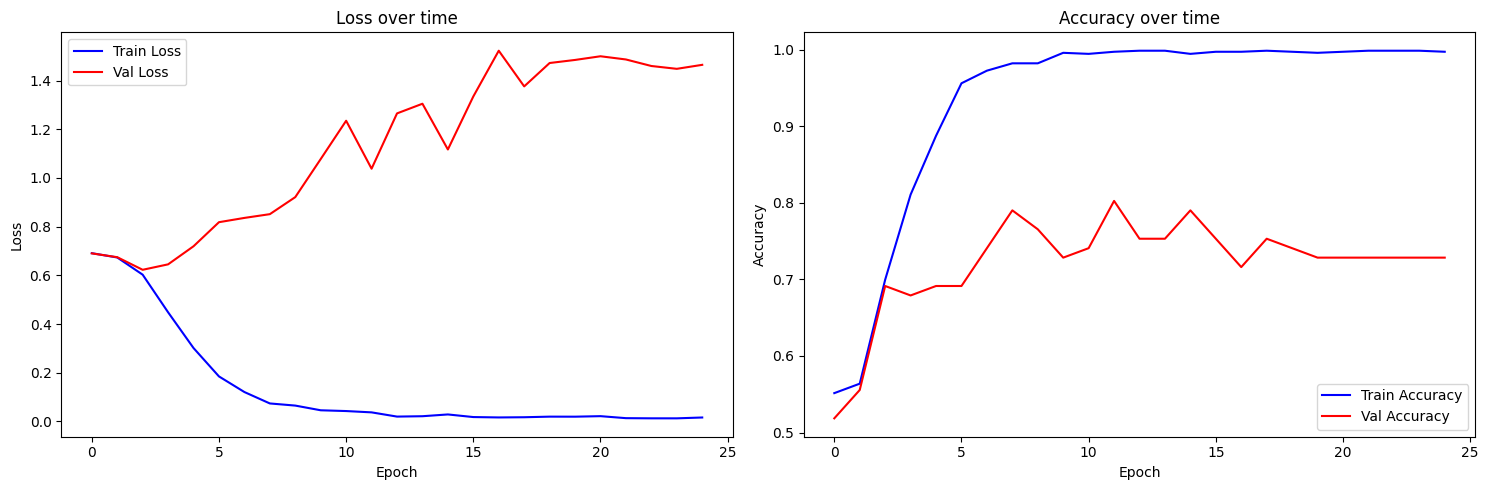

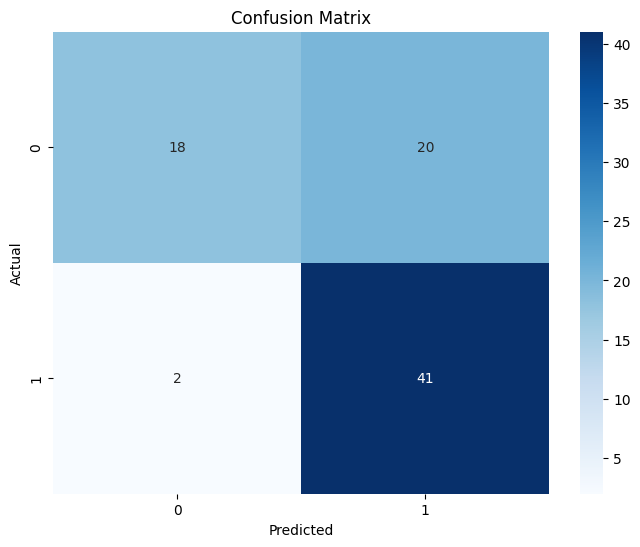

In [24]:
if __name__ == "__main__":
    model, submission_df, metrics, val_dataset, classical_results, stats_df = main()

    train_losses, val_losses, train_accuracies, val_accuracies = metrics
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    plot_confusion_matrix(model, val_loader)

**Comparison and Conclusions:**


**Accuracy:** the deep learning model achieves higher accuracy compared to the classical models. This is often the case with deep learning models, especially for complex tasks like text classification.

**Training Time:** classical models generally train much faster than deep learning models. the code likely shows a significant difference in training time between the two types of models.

**Interpretability:** classical models are generally more interpretable than deep learning models. it's easier to understand how they make predictions, while deep learning models are often considered "black boxes."

**data requirements:** deep learning models usually require more data to train effectively compared to classical models.

**Multilingual Capabilities:** XLM-RoBERTa is specifically designed for multilingual text, good for datasets with multiple languages. classical models need specific adaptations to handle multilingual data.

**Summary:**
if accuracy is the primary concern and sufficient data and computational resources are available, deep learning models like XLM-RoBERTa are often the better choice.
if training time or interpretability is more important, classical models can be suitable alternatives.

In [ ]:
model = CustomClassifier()

model.load_state_dict(torch.load('best_model.pt'))

model.to(DEVICE)

model.eval()

text1 = "hello my name is Lidor"
text2 = "The hydraulic system is operating at 2500 PSI, maintaining optimal torque efficiency for industrial automation."

with torch.no_grad():
  # tokenize the text and make prediction for text1
  encoding1 = tokenizer(
      text1,
      truncation=True,
      max_length=MAX_LENGTH,
      padding='max_length',
      return_tensors='pt'
  )

  # move tensors to the appropriate device
  encoding1 = {k: v.to(DEVICE) for k, v in encoding1.items()}

  # call the model with the tokenized inputs
  prediction1 = model(**encoding1)[1]

  # get the predicted class index (Corrected line)
  predicted_class_index1 = torch.argmax(prediction1, dim=1).item()  # .item() to get a single value

  # convert the index to a label
  prediction_label1 = "H" if predicted_class_index1 == 0 else "M"

  # print the prediction
  print(f"Prediction for text1: {prediction_label1}")

  # tokenize the text and make prediction for text2
  encoding2 = tokenizer(
      text2,
      truncation=True,
      max_length=MAX_LENGTH,
      padding='max_length',
      return_tensors='pt'
  )

  # move tensors to the appropriate device
  encoding2 = {k: v.to(DEVICE) for k, v in encoding2.items()}

  # call the model with the tokenized inputs
  prediction2 = model(**encoding2)[1]

  # get the predicted class index (Corrected line)
  predicted_class_index2 = torch.argmax(prediction2, dim=1).item()  # .item() to get a single value

  # convert the index to a label
  prediction_label2 = "H" if predicted_class_index2 == 0 else "M"

  # print the prediction
  print(f"Prediction for text2: {prediction_label2}")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-1dfb30538df9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

Prediction for text1: H
Prediction for text2: M
